<a href="https://colab.research.google.com/github/billyrdavis1985-bot/neural-network/blob/main/neural_network_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from matplotlib import cm
%matplotlib inline

In [ ]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

In [ ]:
layer_dims = [2, 20, 10, 5, 1]  # our architecture
parameters = initialize_parameters_deep(layer_dims)

print("W1 shape:", parameters["W1"].shape)  # (20, 2)
print("b1 shape:", parameters["b1"].shape)  # (20, 1)
print("W4 shape:", parameters["W4"].shape)  # (1, 5)

W1 shape: (20, 2)
b1 shape: (20, 1)
W4 shape: (1, 5)


In [ ]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)

    if activation == "relu":
        A = relu(Z)
    elif activation == "sigmoid":
        A = sigmoid(Z)

    activation_cache = Z
    cache = (linear_cache, activation_cache)
    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2  # number of layers

    # ReLU layers (1 to L-1)
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev,
                                             parameters['W' + str(l)],
                                             parameters['b' + str(l)],
                                             activation="relu")
        caches.append(cache)

    # Sigmoid output layer
    AL, cache = linear_activation_forward(A,
                                          parameters['W' + str(L)],
                                          parameters['b' + str(L)],
                                          activation="sigmoid")
    caches.append(cache)

    return AL, caches

In [ ]:
# Quick shape test
np.random.seed(1)
X_test = np.random.randn(2, 100)  # 2 features, 100 examples

AL, caches = L_model_forward(X_test, parameters)

print("AL shape:", AL.shape)          # Expected: (1, 100)
print("Number of caches:", len(caches))  # Expected: 4
print("Sample predictions:", AL[0, :5])  # Should be values between 0 and 1

AL shape: (1, 100)
Number of caches: 4
Sample predictions: [0.11511023 0.43552272 0.46503609 0.43550107 0.17971414]


X shape: (2, 400)
Y shape: (1, 400)


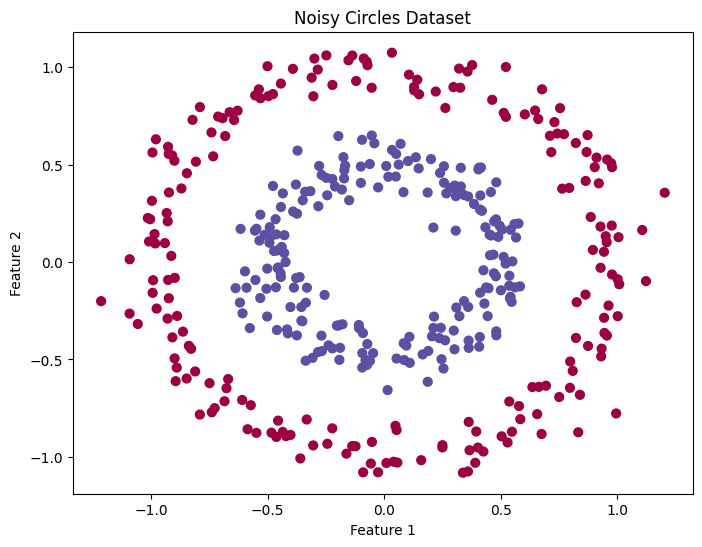

In [ ]:
# Generate noisy circles dataset
noisy_circles = sklearn.datasets.make_circles(n_samples=400, factor=.5, noise=.08, random_state=1)
X, Y = noisy_circles
X = X.T  # Shape: (2, m)
Y = Y.reshape(1, -1)  # Shape: (1, m)

print("X shape:", X.shape)  # (2, 400)
print("Y shape:", Y.shape)  # (1, 400)

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X[0, :], X[1, :], c=Y.flatten(), s=40, cmap=plt.cm.Spectral)
plt.title("Noisy Circles Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [ ]:
def compute_cost(AL, Y):
    """
    Compute binary cross-entropy cost

    Arguments:
    AL -- probability vector (1, m)
    Y -- true labels (1, m)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]

    # Avoid log(0) issues
    AL = np.clip(AL, 1e-15, 1 - 1e-15)

    cost = -1/m * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))

    cost = np.squeeze(cost)  # Turn [[17]] -> 17
    return cost

In [ ]:
# Re-initialize parameters (for fresh start)
parameters = initialize_parameters_deep([2, 20, 10, 5, 1])

# Forward pass
AL, caches = L_model_forward(X, parameters)

# Compute initial cost (should be around 0.693 = -ln(0.5) since random init ≈ 0.5)
cost = compute_cost(AL, Y)
print("Initial cost:", cost)

Initial cost: 0.6586102994278014


In [ ]:
def linear_backward(dZ, cache):
    """
    Linear part of backward propagation for a single layer

    Arguments:
    dZ -- Gradient of cost with respect to Z
    cache -- (A_prev, W, b) from forward

    Returns:
    dA_prev -- Gradient w.r.t. activation of previous layer
    dW -- Gradient w.r.t. W
    db -- Gradient w.r.t. b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [ ]:
def linear_activation_backward(dA, cache, activation):
    """
    Backward for one layer (LINEAR -> ACTIVATION)

    Arguments:
    dA -- post-activation gradient
    cache -- (linear_cache, activation_cache) = ((A_prev, W, b), Z)
    activation -- "relu" or "sigmoid"

    Returns:
    dA_prev, dW, db
    """
    linear_cache, activation_cache = cache
    Z = activation_cache

    if activation == "relu":
        dZ = dA * relu_derivative(Z)  # dA * (1 if Z>0 else 0)
    elif activation == "sigmoid":
        s = sigmoid(Z)
        dZ = dA * s * (1 - s)  # sigmoid derivative

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [ ]:
def L_model_backward(AL, Y, caches):
    """
    Full backward propagation

    Returns:
    grads -- dictionary with "dW1", "db1", ..., "dWL", "dbL"
    """
    grads = {}
    L = len(caches)  # number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    # Output layer (sigmoid)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))  # derivative of cost w.r.t. AL

    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, "sigmoid")
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp

    # Hidden layers (ReLU)
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_prev_temp, current_cache, "relu")
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp

    return grads

In [ ]:
# Test backprop
AL, caches = L_model_forward(X, parameters)
grads = L_model_backward(AL, Y, caches)

# Check a few gradient shapes
print("dW1 shape:", grads["dW1"].shape)  # Should be (20, 2)
print("db1 shape:", grads["db1"].shape)  # (20, 1)
print("dW4 shape:", grads["dW4"].shape)  # (1, 5)

dW1 shape: (20, 2)
db1 shape: (20, 1)
dW4 shape: (1, 5)


In [ ]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent

    Arguments:
    parameters -- dict with W1, b1, ...
    grads -- dict with dW1, db1, ...
    learning_rate -- scalar

    Returns:
    parameters -- updated parameters
    """
    L = len(parameters) // 2  # number of layers

    for l in range(1, L + 1):
        parameters["W" + str(l)] -= learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)]

    return parameters

In [ ]:
def L_layer_model(X, Y, layer_dims, learning_rate=0.0075, num_iterations=3000, print_cost=True):
    """
    Full deep neural network training
    """
    np.random.seed(1)
    costs = []

    # Initialize
    parameters = initialize_parameters_deep(layer_dims)

    # Loop (gradient descent)
    for i in range(num_iterations):
        # Forward
        AL, caches = L_model_forward(X, parameters)

        # Cost
        cost = compute_cost(AL, Y)

        # Backward
        grads = L_model_backward(AL, Y, caches)

        # Update
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print cost every 100 iterations
        if print_cost and i % 100 == 0:
            print(f"Cost after iteration {i}: {cost:.6f}")
            costs.append(cost)

    # Plot cost curve
    plt.figure(figsize=(8, 5))
    plt.plot(costs)
    plt.title("Cost over Iterations")
    plt.xlabel("Iterations (x100)")
    plt.ylabel("Cost")
    plt.show()

    return parameters

Cost after iteration 0: 0.658610
Cost after iteration 100: 0.544405
Cost after iteration 200: 0.310314
Cost after iteration 300: 0.156702
Cost after iteration 400: 0.081441
Cost after iteration 500: 0.046877
Cost after iteration 600: 0.030346
Cost after iteration 700: 0.021489
Cost after iteration 800: 0.016176
Cost after iteration 900: 0.012706
Cost after iteration 1000: 0.010312
Cost after iteration 1100: 0.008587
Cost after iteration 1200: 0.007288
Cost after iteration 1300: 0.006286
Cost after iteration 1400: 0.005496
Cost after iteration 1500: 0.004861
Cost after iteration 1600: 0.004342
Cost after iteration 1700: 0.003913
Cost after iteration 1800: 0.003551
Cost after iteration 1900: 0.003244
Cost after iteration 2000: 0.002980
Cost after iteration 2100: 0.002752
Cost after iteration 2200: 0.002552
Cost after iteration 2300: 0.002376
Cost after iteration 2400: 0.002220


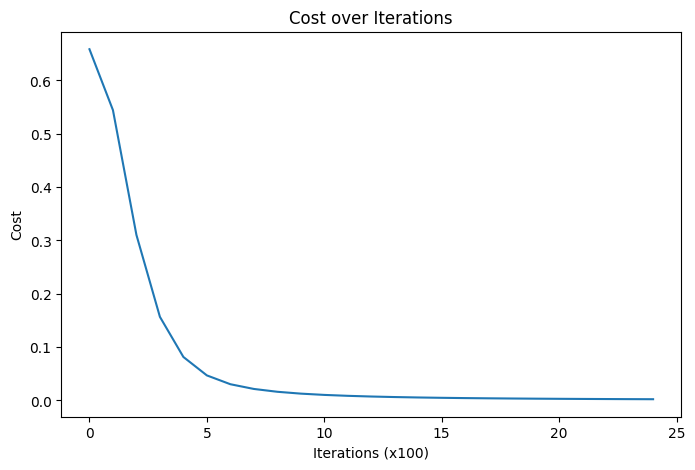

In [ ]:
# Train the model
parameters = L_layer_model(X, Y, [2, 20, 10, 5, 1],
                           learning_rate=0.05,   # Higher LR for faster convergence on this dataset
                           num_iterations=2500,
                           print_cost=True)

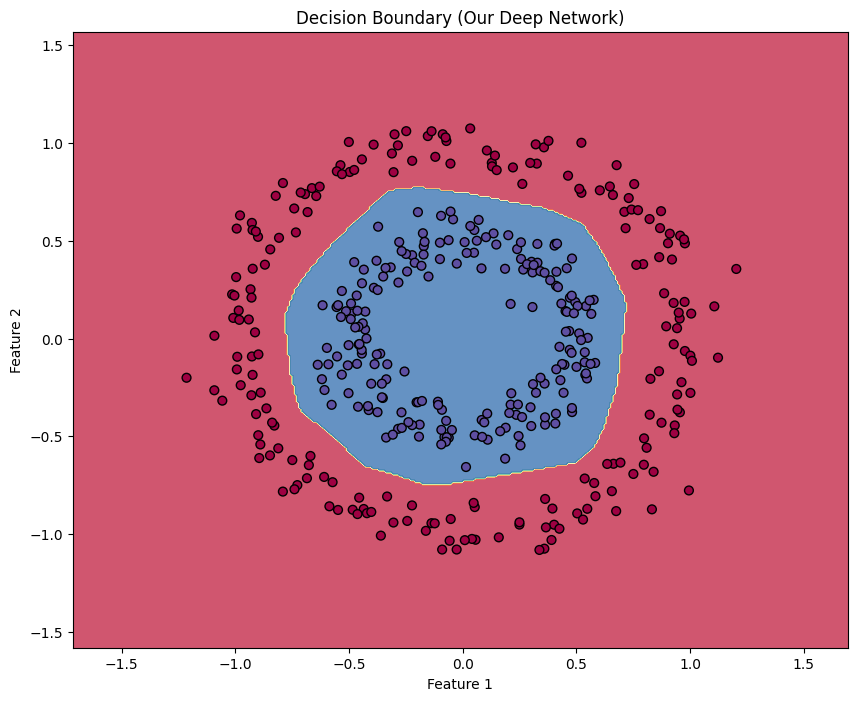

In [ ]:
def predict(X, parameters):
    AL, _ = L_model_forward(X, parameters)
    predictions = (AL > 0.5).astype(int)
    return predictions

def plot_decision_boundary(X, Y, parameters):
    # Create grid
    x_min, x_max = X[0, :].min() - 0.5, X[0, :].max() + 0.5
    y_min, y_max = X[1, :].min() - 0.5, X[1, :].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict on grid
    grid_points = np.c_[xx.ravel(), yy.ravel()].T
    Z = predict(grid_points, parameters)
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[0, :], X[1, :], c=Y.flatten(), s=40, cmap=plt.cm.Spectral, edgecolors='k')
    plt.title("Decision Boundary (Our Deep Network)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Plot it!
plot_decision_boundary(X, Y, parameters)

In [ ]:
def calculate_accuracy(X, Y, parameters):
    predictions = predict(X, parameters)
    accuracy = np.mean(predictions == Y) * 100
    return accuracy

# After training
accuracy = calculate_accuracy(X, Y, parameters)
print(f"Train Accuracy: {accuracy:.2f}%")

Train Accuracy: 100.00%


In [ ]:
def predict(X, parameters):
    """
    Make predictions using the trained model

    Arguments:
    X -- input data (n_x, m)
    parameters -- trained parameters

    Returns:
    predictions -- vector of predictions (1, m) with 0 or 1
    """
    AL, _ = L_model_forward(X, parameters)
    predictions = (AL > 0.5).astype(int)  # This ensures it's 0s and 1s, shape (1, m)
    return predictions

In [ ]:
def calculate_accuracy(X, Y, parameters):
    predictions = predict(X, parameters)

    # Ensure both are (1, m) and flattened for comparison
    accuracy = np.mean(predictions == Y) * 100

    print(f"Training Accuracy: {accuracy:.2f}%")
    return accuracy

In [ ]:
# After your training finishes
calculate_accuracy(X, Y, parameters)

Training Accuracy: 100.00%


np.float64(100.0)

X shape: (2, 400)
Y shape: (1, 400)


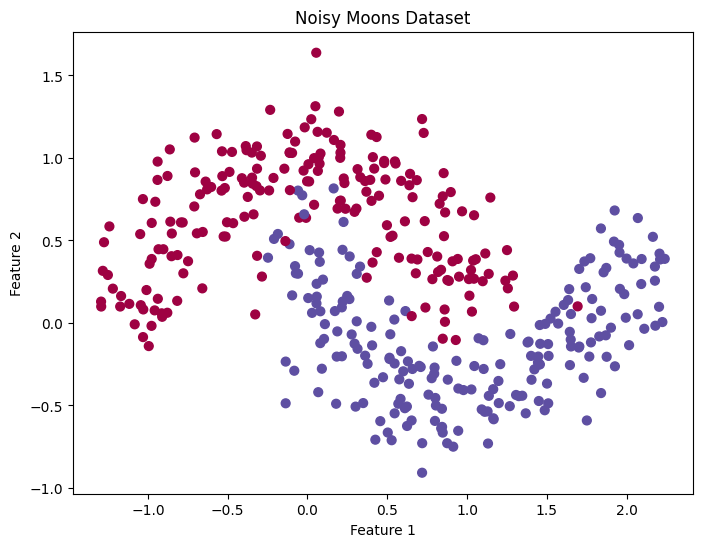

In [ ]:
# Generate noisy moons dataset
noisy_moons = sklearn.datasets.make_moons(n_samples=400, noise=0.20, random_state=1)
X, Y = noisy_moons
X = X.T  # Shape: (2, m)
Y = Y.reshape(1, -1)  # Shape: (1, m)

print("X shape:", X.shape)  # (2, 400)
print("Y shape:", Y.shape)  # (1, 400)

# Plot the raw data
plt.figure(figsize=(8, 6))
plt.scatter(X[0, :], X[1, :], c=Y.flatten(), s=40, cmap=plt.cm.Spectral)
plt.title("Noisy Moons Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

Cost after iteration 0: 1.028668
Cost after iteration 100: 0.464428
Cost after iteration 200: 0.358316
Cost after iteration 300: 0.262167
Cost after iteration 400: 0.241227
Cost after iteration 500: 0.227376
Cost after iteration 600: 0.214579
Cost after iteration 700: 0.198802
Cost after iteration 800: 0.182340
Cost after iteration 900: 0.166580
Cost after iteration 1000: 0.150062
Cost after iteration 1100: 0.134031
Cost after iteration 1200: 0.121507
Cost after iteration 1300: 0.110947
Cost after iteration 1400: 0.102922
Cost after iteration 1500: 0.097091
Cost after iteration 1600: 0.092678
Cost after iteration 1700: 0.089169
Cost after iteration 1800: 0.086267
Cost after iteration 1900: 0.083972
Cost after iteration 2000: 0.081645
Cost after iteration 2100: 0.079467
Cost after iteration 2200: 0.078103
Cost after iteration 2300: 0.076929
Cost after iteration 2400: 0.075866


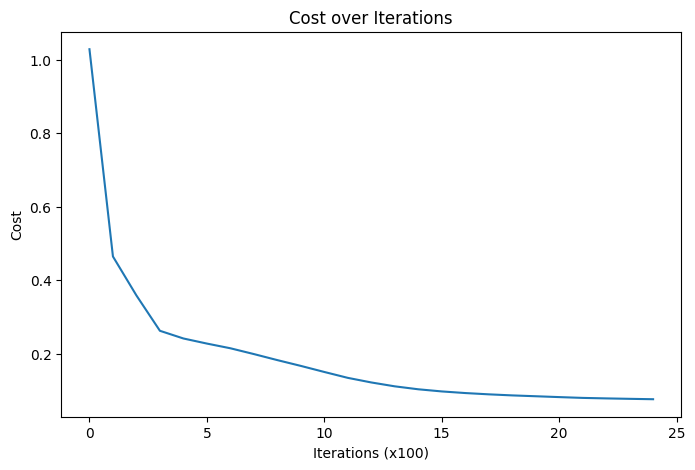

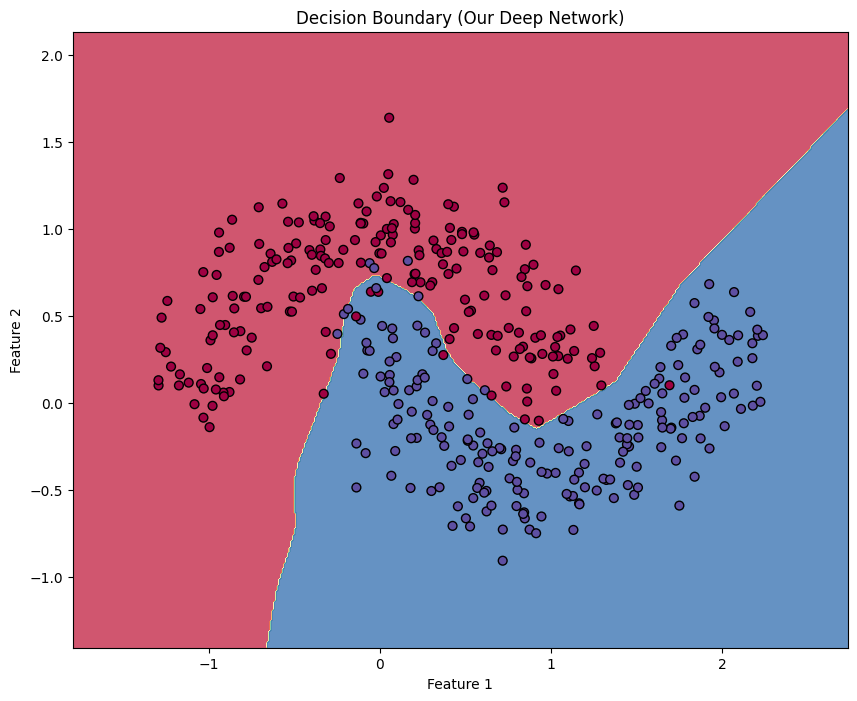

Training Accuracy: 97.00%


np.float64(97.0)

In [ ]:
# Re-initialize and train
parameters = L_layer_model(X, Y, [2, 20, 10, 5, 1],
                           learning_rate=0.05,
                           num_iterations=2500,
                           print_cost=True)

# Plot the beautiful decision boundary
plot_decision_boundary(X, Y, parameters)

# Check accuracy
calculate_accuracy(X, Y, parameters)

X shape: (2, 400)
Y shape: (1, 400)


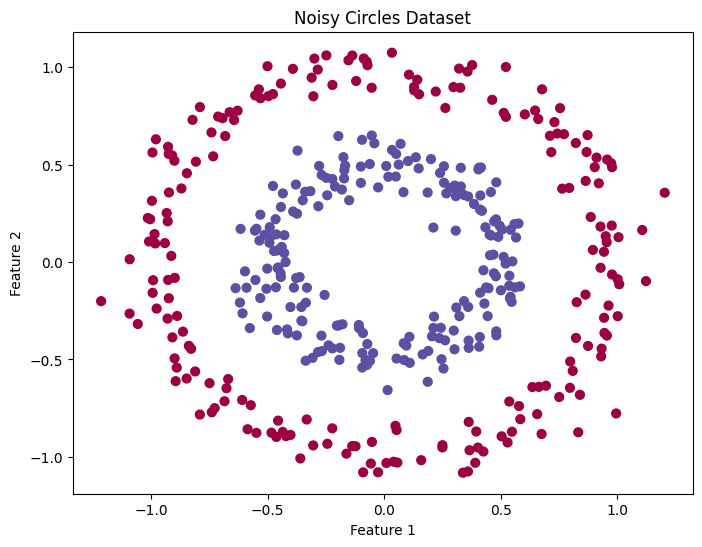

In [ ]:
# Generate noisy circles dataset
noisy_circles = sklearn.datasets.make_circles(n_samples=400, factor=.5, noise=.08, random_state=1)
X, Y = noisy_circles
X = X.T  # Shape: (2, m)
Y = Y.reshape(1, -1)  # Shape: (1, m)

print("X shape:", X.shape)  # (2, 400)
print("Y shape:", Y.shape)  # (1, 400)

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X[0, :], X[1, :], c=Y.flatten(), s=40, cmap=plt.cm.Spectral)
plt.title("Noisy Circles Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [ ]:
def compute_cost(AL, Y):
    """
    Compute binary cross-entropy cost

    Arguments:
    AL -- probability vector (1, m)
    Y -- true labels (1, m)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]

    # Avoid log(0) issues
    AL = np.clip(AL, 1e-15, 1 - 1e-15)

    cost = -1/m * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))

    cost = np.squeeze(cost)  # Turn [[17]] -> 17
    return cost

In [ ]:
# Re-initialize parameters (for fresh start)
parameters = initialize_parameters_deep([2, 20, 10, 5, 1])

# Forward pass
AL, caches = L_model_forward(X, parameters)

# Compute initial cost (should be around 0.693 = -ln(0.5) since random init ≈ 0.5)
cost = compute_cost(AL, Y)
print("Initial cost:", cost)

Initial cost: 0.6586102994278014
